In [2]:
import sys
sys.path.append('../../../..')
sys.path.append('../../../../lib/src/')
import torch
from torch import nn
import os
import numpy as np
from matplotlib import pyplot as plt
import math
import lightning as L
import logging
import torch.nn.functional as F
from sklearn.decomposition import PCA


from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs,Encoder_Chairs_GPVAE, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config, LVAE_IAF, GPVAE, GPVAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.trainers.training_callbacks import WandbCallback

sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper, MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from geometric_perspective_on_vaes.sampling import build_metrics, hmc_sampling

def plot_sequence(X):

    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(10, 10))
    for i in range(num_seq):
        for j in range(num_obs):
            plt.subplot(num_seq, num_obs, i*num_obs+j+1)
            plt.imshow(X[i, j].transpose(1, 2, 0))
            plt.axis('off')

    plt.show()
    logger.setLevel(old_level)

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )

#Defining these important global variables
PROB_MISSING_DATA = 0.4
BATCH_SIZE = 256

    
%reload_ext autoreload
%autoreload 2
!nvidia-smi

Mon Sep  9 15:37:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   35C    P8              9W /   70W |     119MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# LDM

In [3]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'


data = torch.load(os.path.join('../../my_data/sprites/Sprites_train.pt'))
train_data = data[:-1000, :-1, :, :, :].to(device) #removing the last obs which is the same as the first
eval_data = data[-1000:, :-1, :, :, :].to(device)
test_data = torch.load(os.path.join('../../my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, :-1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

if not os.path.exists(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt'):
    train_seq_mask = make_batched_masks(train_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    eval_seq_mask = make_batched_masks(eval_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    test_seq_mask = make_batched_masks(test_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)

    torch.save(train_seq_mask, f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(eval_seq_mask, f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(test_seq_mask, f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
else:
    print('Loading masks...')
    train_seq_mask = torch.load(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    eval_seq_mask = torch.load(f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    test_seq_mask = torch.load(f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')

train_data = train_data[train_seq_mask]
eval_data = eval_data[eval_seq_mask]
test_data = test_data[test_seq_mask]

train_dataset = My_Dataset(train_data)
eval_dataset = My_Dataset(eval_data)
test_dataset = My_Dataset(test_data)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])


In [4]:
input_dim = (3, 64, 64)
f = 32 #subsampling factor
new_num_channels = 3
latent_dim = new_num_channels* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='pre-trained_vae',
num_epochs=100,
learning_rate=1e-3,
per_device_train_batch_size=256,
per_device_eval_batch_size=256,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=25,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 3, "factor": 0.8})


model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
encoder = Encoder_Chairs(model_config)
decoder = Decoder_Chairs(model_config)
device = 'cuda'

vae = VAE(model_config=model_config, encoder=encoder, decoder=decoder).to(device)


Latent dim: 12


## First-stage model

In [ ]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name=f"pre_training_VAE_latdim12_missing_{PROB_MISSING_DATA}", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

In [ ]:
vae = vae.to('cuda')
pipeline = TrainingPipeline(
    training_config=training_config,
    model=vae
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset,
    #callbacks=callbacks
)

In [ ]:
vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-09-09_15-39-08/final_model')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


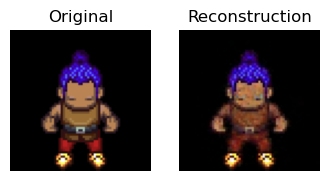

In [15]:
idx = 25567
x = train_dataset[idx]
vae = vae.to('cpu')
out = vae(x)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.data.cpu().permute(1, 2, 0))
plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out['recon_x'].data.cpu().permute(1, 2, 0))
plt.title('Reconstruction')
plt.axis('off')
plt.show()

## LDM per se

In [16]:
# Keeping only last observations

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
data = torch.load(os.path.join('../../my_data/sprites/Sprites_train.pt'))
train_data = data[:-1000, :-1, :, :, :].to(device) #removing the last obs which is the same as the first
eval_data = data[-1000:, :-1, :, :, :].to(device)
test_data = torch.load(os.path.join('../../my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, :-1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

if not os.path.exists(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt'):
    train_seq_mask = make_batched_masks(train_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    eval_seq_mask = make_batched_masks(eval_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    test_seq_mask = make_batched_masks(test_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)

    torch.save(train_seq_mask, f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(eval_seq_mask, f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(test_seq_mask, f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
else:
    print('Loading masks...')
    train_seq_mask = torch.load(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    eval_seq_mask = torch.load(f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    test_seq_mask = torch.load(f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')

#Slicing where the last observation is not missing and keeping only the last observation
train_data = train_data[train_seq_mask[:, -1] == 1, -1] 
eval_data = eval_data[eval_seq_mask[:, -1] == 1, -1]
test_data = test_data[test_seq_mask[:, -1] == 1, -1]
print(train_data.shape)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])
Loading masks...
torch.Size([4608, 3, 64, 64])


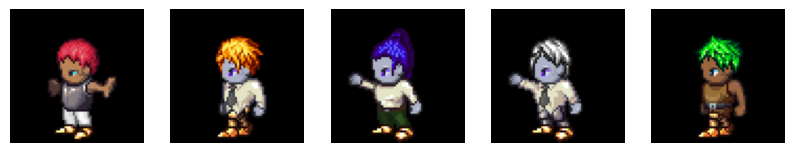

In [17]:
#check
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_data[i].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [18]:
input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

device = 'cuda'
vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-09-09_15-39-08/final_model').to(device)
vae.eval()

Latent dim: 12


VAE(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
  

In [19]:

######## UNET #######
# in_channels = 3
# out_channels = 3
# channels = 64
# n_res_blocks = 2
# attention_levels = [3]
# channel_multipliers = (1, 2, 2, 4)
# n_heads = 2

in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

h, w = 64//f, 64//f


z = torch.randn(1, 3, h, w)
print("Shape of input U-NET: ", z.shape)
empty_prompt_embed = None
print("Shape of output: ", unet(z, torch.tensor([10]), empty_prompt_embed).shape)
print("Number of trainable params: ", sum(p.numel() for p in unet.parameters() if p.requires_grad))

latent_scaling_factor = 1
n_steps = 1000
linear_start =  0.00085
linear_end = 0.0012


latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
print("Number of trainable params (should not change): ", sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

Shape of input U-NET:  torch.Size([1, 3, 2, 2])
Shape of output:  torch.Size([1, 3, 2, 2])
Number of trainable params:  2223043
Number of trainable params (should not change):  2223043


In [ ]:
n_steps = 1000
linear_start =  0.00085
linear_end = 0.012
latent_scaling_factor = 1
lr = 1e-4
BATCH_SIZE = 256
MAX_EPOCHS = 50

vae = vae.to('cuda')
latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
model = LitLDM(ldm = latent_diffusion, vae = vae, lr = lr).to('cuda')

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers = 12)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=800, num_workers = 12)

trainer = L.Trainer(max_epochs=MAX_EPOCHS,
                     default_root_dir='ldm', accelerator = 'gpu', 
                     check_val_every_n_epoch=5)



trainer.fit(model, train_loader, val_loader)

#model = LitLDM.load_from_checkpoint('ldm/lightning_logs/version_3/checkpoints/epoch=149-step=4800.ckpt', ldm = latent_diffusion, vae = vae, latent_dim = latent_dim).to('cuda')

# LLDM

In [37]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
data = torch.load(os.path.join('../../my_data/sprites/Sprites_train.pt'))
train_data = data[:-1000, :-1, :, :, :].to(device) #removing the last obs which is the same as the first
eval_data = data[-1000:, :-1, :, :, :].to(device)
test_data = torch.load(os.path.join('../../my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, :-1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

if not os.path.exists(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt'):
    train_seq_mask = make_batched_masks(train_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    eval_seq_mask = make_batched_masks(eval_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    test_seq_mask = make_batched_masks(test_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)

    torch.save(train_seq_mask, f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(eval_seq_mask, f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(test_seq_mask, f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
else:
    print('Loading masks...')
    train_seq_mask = torch.load(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    eval_seq_mask = torch.load(f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    test_seq_mask = torch.load(f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')

train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool)

#test_seq_mask = torch.ones_like(test_seq_mask, requires_grad=False).type(torch.bool)
train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)


torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])
Loading masks...


In [ ]:
PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-09-09_15-39-08/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_0/checkpoints/epoch=49-step=900.ckpt'

device = 'cuda'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _, _ = vae.retrieveG(train_data, verbose = True, T_multiplier=5, device = device, addStdNorm=True)

in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

In [24]:
model_config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.3,
    n_hidden_in_made=2,
    n_made_blocks=4,
    warmup=0,
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)


device = 'cuda'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
temperature = 1


#############
# lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
#                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
#                 precomputed_zT_samples=zT_samples, GM = GM, verbose = True)
lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler, verbose = True, temp = temperature)
#lvae = LVAE_IAF(model_config, encoder, decoder).cuda()



#lldm.load_state_dict(torch.load('LLDM_IAF_training_0.3.pt'))
#lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-09-07_12-09-45/final_model/model.pt')['model_state_dict'])

Diffusion time steps  [997 831 665 499 333 167   1]
Running on  cuda:0
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 1.1e+06
Number of total parameters: 4.4e+06


In [8]:
lvae = LVAE_IAF(model_config, encoder, decoder).cuda()
lvae.load_state_dict(torch.load('lldm/LVAE_IAF_training_2024-09-06_15-53-04/final_model/model.pt')['model_state_dict'])

<All keys matched successfully>

In [ ]:
lldm.beta = 0.2

lrs = [1e-4]
for i in range(len(lrs)):
    LR = lrs[i]
    optimizer = torch.optim.Adam(lldm.parameters(), lr=LR)
    training_config = BaseTrainerConfig(
            num_epochs=50,
            learning_rate=LR,
            batch_size=BATCH_SIZE,
            steps_saving=50,
            steps_predict=100,
            shuffle=True,
            output_dir='lldm'
        )

    ### Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)
    trainer = BaseTrainer(
                model=lldm,
                train_dataset=train_dataset,
                eval_dataset=eval_dataset,
                training_config=training_config,
                optimizer=optimizer,
                scheduler=scheduler,
                #callbacks=callbacks
            )
    trainer.train()

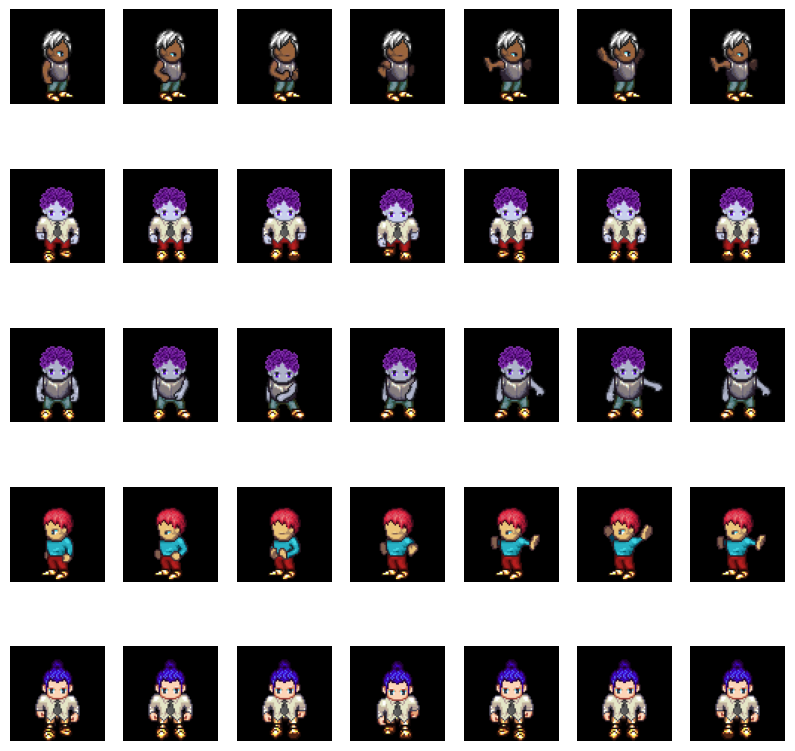

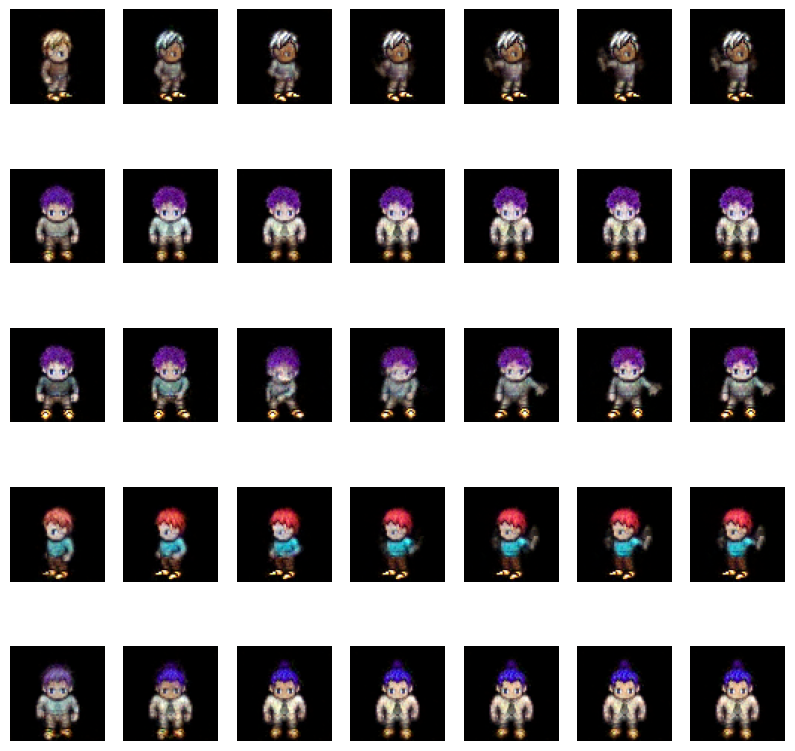

In [28]:
lldm = lldm.to('cpu')
lldm.device = 'cpu'
eval_dataset.data = eval_dataset.data.to('cpu')
_, recon_x = lldm.reconstruct(eval_dataset[5:10], vi_index=3)
plot_sequence(eval_data[5:10])
plot_sequence(recon_x.reshape(5, 7, 3, 64, 64))

In [29]:
train_embeddings = [] 
log_vars = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
for i, x in enumerate(train_loader):
    x = x.to('cpu')
    out = lldm.encoder(x)
    z = out.embedding.reshape(-1, 7, 12)
    log_var = out.log_covariance
    train_embeddings.append(z.cpu().detach())
    log_vars.append(log_var.cpu().detach())
train_embeddings = torch.stack(train_embeddings).squeeze(1).reshape(-1, 7, 12)
print(train_embeddings.shape)


torch.Size([8000, 7, 12])


PCA on the whole dataset (56000 data points)


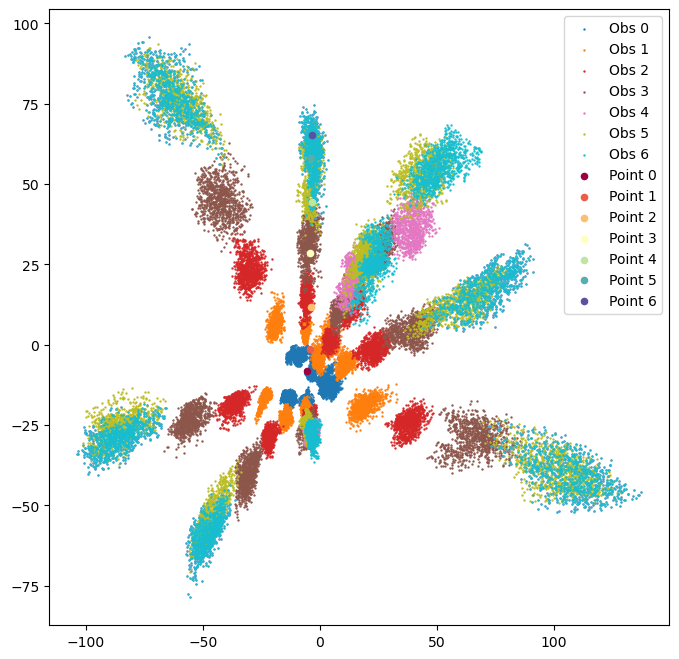

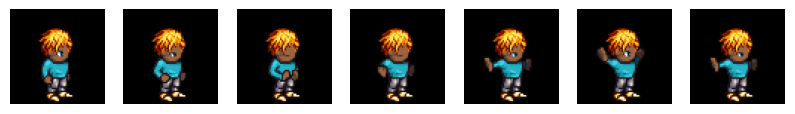

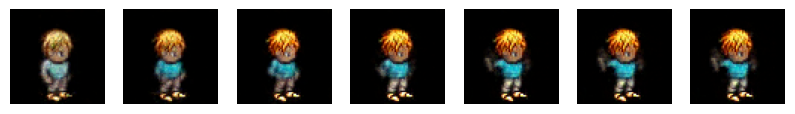

Reconstruction loss: 26.31699562072754


In [30]:
pca = PCA(n_components=2)
num_obs = train_embeddings.shape[1]
lldm = lldm.to('cpu')
#torch.manual_seed(46)

###################
vi_index = 5
projection_index = 'all' # 'all', 'pre
displayed_indexes = range(num_obs)  #range(num_obs)
train_point = 116
lldm.temperature = 1
##################


if projection_index == 'all':
    gathered = train_embeddings.reshape(-1, latent_dim)
    pca.fit(gathered)
    print(f'PCA on the whole dataset ({gathered.shape[0]} data points)')
elif projection_index == 'pre':
    last_preembed = torch.load('preembedding-last.pt')
    #last_preembed = torch.load('pre-embeddings2.pt')
    #last_preembed = torch.load('pre-embeddings-priordecalee.pt')
    pca.fit(last_preembed)
else:
    pca.fit(train_embeddings[:, projection_index, :].reshape(-1, latent_dim))

train_embeddings_pca = []
for i in range(num_obs):
    train_embeddings_pca.append(pca.transform(train_embeddings[:, i, :].reshape(-1, latent_dim)))

train_embeddings_pca = np.stack(train_embeddings_pca).transpose(1, 0, 2)



plt.figure(figsize=(8, 8))
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

x = train_dataset[train_point]

z_seq, x_rec = lldm.reconstruct(x, vi_index = vi_index)

# sampler = lldm.ddim_sampler
# start = train_embeddings[train_point, vi_index, :].cuda().reshape(1, model.c, model.h, model.w)
# _, z_seq, _ = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)
# z_seq = z_seq[:-1].reshape(-1, latent_dim)
# x_rec = lldm.decoder(z_seq).reconstruction


z_seq_pca = pca.transform(z_seq.cpu().detach())

colors = plt.get_cmap('Spectral', 7)
for i in range(num_obs):
    plt.scatter(z_seq_pca[i, 0], z_seq_pca[i, 1], s=20, color=colors(i), label=f'Point {i}')


plt.legend()
plt.show()

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [ ]:
model_config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.3,
    n_hidden_in_made=2,
    n_made_blocks=4,
    warmup=10,
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)


device = 'cuda'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
lvae = LVAE_IAF(model_config, encoder, decoder).cuda()


LR = 5*1e-4
optimizer = torch.optim.Adam(lvae.parameters(), lr=LR)
training_config = BaseTrainerConfig(
        num_epochs=80,
        learning_rate=LR,
        batch_size=256,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )

### Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)
trainer = BaseTrainer(
            model=lvae,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
            #callbacks=callbacks
        )
trainer.train()

In [ ]:
input_dim = (3, 64, 64)
latent_dim = 12
beta = 1
n_hidden_in_made = 3
n_made_blocks = 2
warmup = 5
context_dim = None
prior = 'standard'
posterior = 'gaussian'
vamp_number_components= 500
linear_scheduling_steps = 10
num_epochs = 150
batch_size = 256
learning_rate=  1e-3 
steps_saving = 50
steps_predict = 100
shuffle_data = True
kernel = "cauchy"
out_channels_time_cnn = 265




config = GPVAEConfig(
    input_dim=input_dim,
    time_length=train_data.shape[1],
    kernel_choice=kernel,
    kernel_scales=1,
    latent_dim=latent_dim,
    sigma=1,
    length_scale=1,
    beta=beta,
    out_channels_time_cnn=out_channels_time_cnn
)

training_config = BaseTrainerConfig(
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        batch_size=batch_size,
        steps_saving=steps_saving,
        steps_predict=steps_predict,
        shuffle=shuffle_data
    )

encoder = Encoder_Chairs_GPVAE(config)
decoder = Decoder_Chairs(config)

#model = LVAE_IAF(config, encoder, decoder).to('cuda')
model = GPVAE(config, encoder, decoder).cuda()

### Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[50, 100, 125, 150],
    gamma=0.5,
    verbose=True
)

trainer = BaseTrainer(
            model=model,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
        )

trainer.train()

In [33]:
model = model.to('cuda')
model.eval()

from tqdm import tqdm
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

mses = []
for i, x in tqdm(enumerate(test_loader)):
    x.data = x.data.to('cuda')
    x.seq_mask = x.seq_mask.to('cuda')
    x.pix_mask = x.pix_mask.to('cuda')
    recon_x = model(x).recon_x.cpu().detach()
    mse = F.mse_loss(recon_x, x.data.cpu().detach(), reduction="none").mean(dim=(1, 2, 3, 4)).detach().cpu()
    mses.append(mse)

mses = torch.cat(mses)
print('MSE:', mses.mean().item())



84it [00:01, 47.73it/s]

MSE: 0.013455068692564964


In [38]:
from tqdm import tqdm
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

rec_losses_lvae, rec_losses_lldm = [], []
lvae = lvae.to('cpu')
lvae.eval()

lldm = lldm.to('cpu')
lldm.device = 'cpu'
lldm.eval()
for i, x in tqdm(enumerate(test_loader)):
    _, x_rec_lvae = lvae.reconstruct(x, vi_index=1, device = 'cpu')
    x_rec_lvae = x_rec_lvae.reshape(-1, 7, 3, 64, 64)
    _, x_rec_lldm = lldm.reconstruct(x, vi_index=3)
    x_rec_lldm = x_rec_lldm.reshape(-1, 7, 3, 64, 64)

    rec_loss_lvae = F.mse_loss(x_rec_lvae.cpu(), x.data, reduction="none").mean(dim=(1, 2, 3, 4)).detach().cpu()
    rec_loss_lldm = F.mse_loss(x_rec_lldm.cpu(), x.data, reduction="none").mean(dim=(1, 2, 3, 4)).detach().cpu()

    rec_losses_lvae.append(rec_loss_lvae)
    rec_losses_lldm.append(rec_loss_lldm)

lvae_loss = torch.cat(rec_losses_lvae).mean().item()
lldm_loss = torch.cat(rec_losses_lldm).mean().item()

print('LVAE loss:', lvae_loss)
print('LLDM loss:', lldm_loss)

84it [00:17,  4.87it/s]

LVAE loss: 0.004080456215888262
LLDM loss: 0.006011070683598518
